In [1]:
from src.inference import OllamaClient, HFClient
client = OllamaClient(base_url="http://localhost:11434")
model="qwen2.5:0.5b-instruct"
# model = "gemma3:4b"
client.download_model(model=model)
client.warmup_model(model=model)
hf_client = HFClient()
hf_client.warmup_model(model_id="finetune")

Model qwen2.5:0.5b-instruct downloaded successfully.
Model qwen2.5:0.5b-instruct warmed up successfully.
Model qwen2.5:0.5b-instruct warmed up successfully.
Model moved to cuda
Model loaded on device: cuda:0
Model moved to cuda
Model loaded on device: cuda:0


In [2]:
from src.parsers.math_parser import MathParser
TEST_SIZE = 100
meta_prompt = (
    "Rewrite the following instruction via rephrasing and/or adding specific requirements. "
    "Use illustrative description if needed. Output the new instruction only."
)

# Match training: num_samples=10000 (adjust if needed)
parser = MathParser(dataset_name="trl-lib/DeepMath-103K", meta_prompt=meta_prompt, num_samples=10000)

# Download (uses same cache behavior and offline fallback as training)
parser.download_dataset()

# Parse -> returns list of parsed dicts in the exact format used by GRPOTrainer
parsed = parser.parse()
testing_set = parsed[0:TEST_SIZE]
display(testing_set[10])


Loading dataset: trl-lib/DeepMath-103K
Cache directory: C:\Users\Owner/.cache/huggingface/datasets
HF_DATASETS_CACHE env: C:\Users\Owner/.cache/huggingface/datasets
Cache directory exists with 3 items
Found DeepMath cache directories: ['trl-lib___deep_math-103_k', 'trl-lib___tldr']


Generating train split:   0%|          | 0/97870 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5152 [00:00<?, ? examples/s]

✓ Loaded dataset: 97870 samples
Parsed 10000 samples from math dataset
Sample parsed structure (first item): {'prompt': [{'content': 'Rewrite the following instruction via rephrasing and/or adding specific requirements. Use illustrative description if needed. Output the new instruction only.', 'role': 'system'}, {'content': "[{'content': 'Express $213_{8}-142_{7}$ as a base 10 integer.', 'role': 'user'}]", 'role': 'user'}], 'solution': '$60$'}
Parsed 10000 samples from math dataset
Sample parsed structure (first item): {'prompt': [{'content': 'Rewrite the following instruction via rephrasing and/or adding specific requirements. Use illustrative description if needed. Output the new instruction only.', 'role': 'system'}, {'content': "[{'content': 'Express $213_{8}-142_{7}$ as a base 10 integer.', 'role': 'user'}]", 'role': 'user'}], 'solution': '$60$'}


{'prompt': [{'content': 'Rewrite the following instruction via rephrasing and/or adding specific requirements. Use illustrative description if needed. Output the new instruction only.',
   'role': 'system'},
  {'content': "[{'content': 'Determine whether every integer $N$ can be expressed as the sum of two primes and the difference of two primes, i.e., $N = p_1 + p_2 - p_3 - p_4$, where $p_1, p_2, p_3, p_4$ are prime numbers.', 'role': 'user'}]",
   'role': 'user'}],
 'solution': 'Yes'}

In [ ]:
from trl.rewards import accuracy_reward
from tqdm import tqdm
from src.evaluators.math_evaluator import MathEvaluator

answers = []
HF_MODEL_ID = "finetune"
HF_MAX_NEW_TOKENS = 5012
EVAL_MAX_TOKENS = 5012
i = 0
evaluator = MathEvaluator(model=model, client=client, temperature=0.0, max_tokens=EVAL_MAX_TOKENS)

for pair in tqdm(testing_set):
    # Use stored strings exactly as produced by MathParser (do NOT eval)
    sys_msg = pair["prompt"][0]["content"]        # meta-prompt string
    user_str = pair["prompt"][1]["content"]       # stored dataset prompt string

    solution = pair["solution"]                    # stored dataset solution string (not used here)

    # Compose rewriter input exactly how training used it
    rewriter_input = f"{sys_msg}\n\n{user_str}"
    rewritten = hf_client.generate(HF_MODEL_ID, rewriter_input,
                                         max_new_tokens=HF_MAX_NEW_TOKENS)

    # Evaluate: compare evaluator output on rewritten vs on stored baseline
    eval_rewritten = client.generate(model=model, prompt=rewritten, temperature=0.0, max_tokens=EVAL_MAX_TOKENS)
    eval_baseline  = client.generate(model=model, prompt=user_str, temperature=0.0, max_tokens=EVAL_MAX_TOKENS)
    
    #evaluate accuracy rewards
    reward_rewritten = evaluator.reward_function([eval_rewritten], solution=[solution])[0]
    reward_baseline  = evaluator.reward_function([eval_baseline], solution=[solution])[0]
    answers.append({
        "original_stored_string": user_str,
        "rewriter_input": rewriter_input,
        "rewritten": rewritten,
        "eval_rewritten": eval_rewritten,
        "eval_baseline": eval_baseline,
        "reward_rewritten": reward_rewritten,
        "reward_baseline": reward_baseline
    })

  0%|          | 0/100 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
  8%|▊         | 8/100 [10:54<2:00:13, 78.41s/it] 

Basic statistics:
  Examples: 100
  Rewriter - mean=0.0000, median=0.0000, std=0.0000
  Baseline - mean=0.0000, median=0.0000, std=0.0000
  Delta (rewriter - baseline) - mean=0.0000, median=0.0000
  Improved examples: 0 (0.0%)
Saved detailed results to rewriter_vs_baseline_rewards.csv


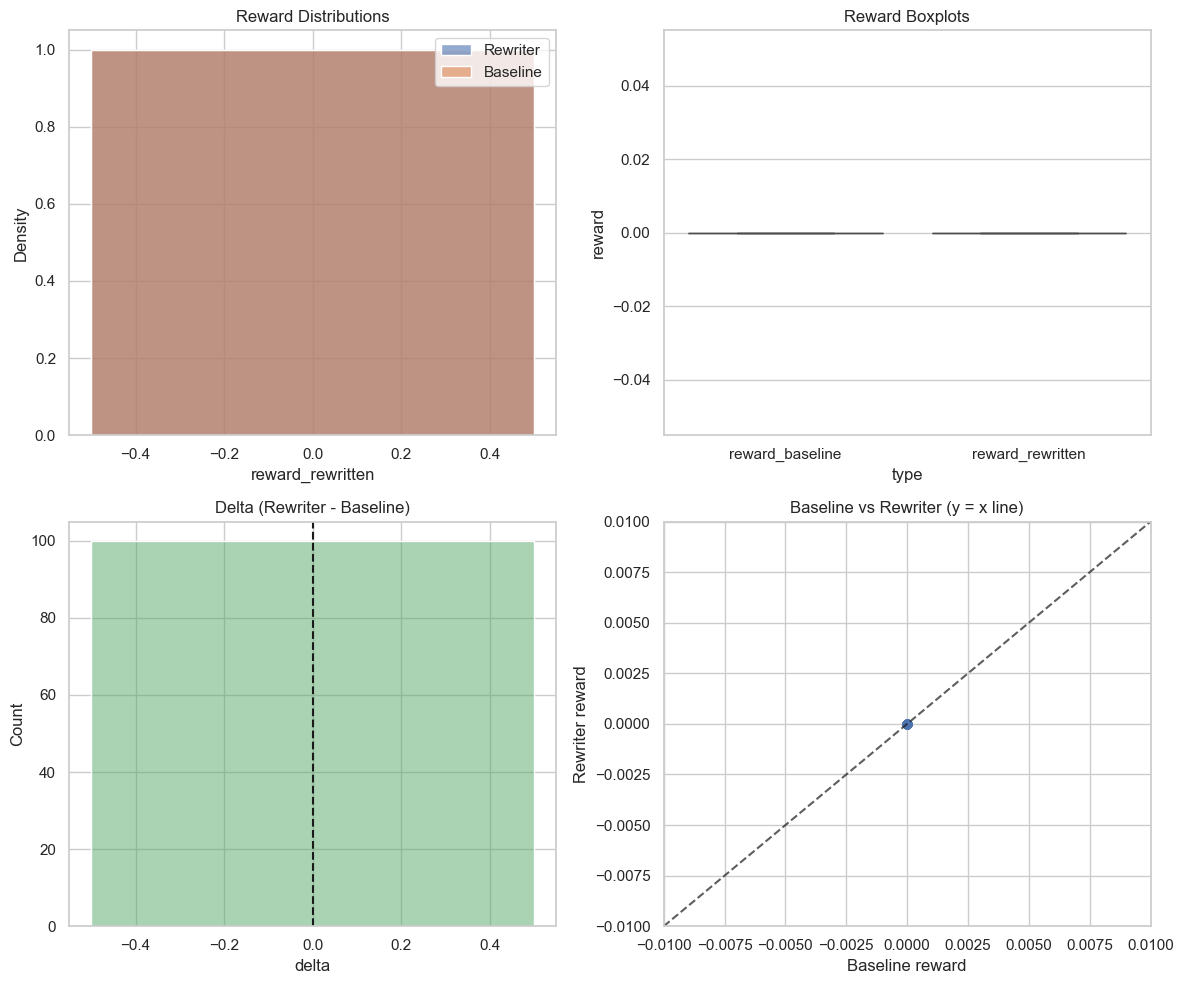

In [ ]:
# Plot rewards and print basic statistics (requires `answers` from the previous cell)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Optional: seaborn for nicer plots if available
try:
    import seaborn as sns
    sns.set(style='whitegrid')
    _has_sns = True
except Exception:
    _has_sns = False

if 'answers' not in globals():
    raise RuntimeError("`answers` not found. Run the earlier cells that populate `answers` first.")

# Build DataFrame
df = pd.DataFrame(answers)
# Ensure reward columns exist
if 'reward_rewritten' not in df.columns or 'reward_baseline' not in df.columns:
    raise RuntimeError("Expected 'reward_rewritten' and 'reward_baseline' in `answers`. Run the scoring cell first.")

# Compute delta
df['delta'] = df['reward_rewritten'] - df['reward_baseline']

# Basic statistics
n = len(df)
stats = {
    'n': n,
    'rewriter_mean': float(df['reward_rewritten'].mean()),
    'rewriter_median': float(df['reward_rewritten'].median()),
    'rewriter_std': float(df['reward_rewritten'].std()),
    'baseline_mean': float(df['reward_baseline'].mean()),
    'baseline_median': float(df['reward_baseline'].median()),
    'baseline_std': float(df['reward_baseline'].std()),
    'delta_mean': float(df['delta'].mean()),
    'delta_median': float(df['delta'].median()),
    'n_improved': int((df['delta'] > 0).sum()),
    'pct_improved': float((df['delta'] > 0).mean() * 100.0)
}

print('Basic statistics:')
print(f"  Examples: {stats['n']}")
print(f"  Rewriter - mean={stats['rewriter_mean']:.4f}, median={stats['rewriter_median']:.4f}, std={stats['rewriter_std']:.4f}")
print(f"  Baseline - mean={stats['baseline_mean']:.4f}, median={stats['baseline_median']:.4f}, std={stats['baseline_std']:.4f}")
print(f"  Delta (rewriter - baseline) - mean={stats['delta_mean']:.4f}, median={stats['delta_median']:.4f}")
print(f"  Improved examples: {stats['n_improved']} ({stats['pct_improved']:.1f}%)")

# Save CSV for later inspection
csv_path = 'rewriter_vs_baseline_rewards.csv'
df.to_csv(csv_path, index=False)
print(f"Saved detailed results to {csv_path}")

# Plotting
plt.rcParams.update({'figure.max_open_warning': 0})
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1) Overlaid histograms for rewards
ax = axes[0, 0]
if _has_sns:
    sns.histplot(df['reward_rewritten'], color='C0', label='Rewriter', kde=True, stat='density', ax=ax, alpha=0.6)
    sns.histplot(df['reward_baseline'], color='C1', label='Baseline', kde=True, stat='density', ax=ax, alpha=0.6)
else:
    ax.hist(df['reward_rewritten'], bins=20, alpha=0.6, label='Rewriter', color='C0', density=True)
    ax.hist(df['reward_baseline'], bins=20, alpha=0.6, label='Baseline', color='C1', density=True)
ax.set_title('Reward Distributions')
ax.legend()

# 2) Boxplot comparison
ax = axes[0, 1]
if _has_sns:
    sns.boxplot(data=df[['reward_baseline', 'reward_rewritten']].melt(var_name='type', value_name='reward'), x='type', y='reward', ax=ax)
else:
    ax.boxplot([df['reward_baseline'].dropna(), df['reward_rewritten'].dropna()], labels=['Baseline', 'Rewriter'])
ax.set_title('Reward Boxplots')

# 3) Delta histogram
ax = axes[1, 0]
if _has_sns:
    sns.histplot(df['delta'], kde=True, ax=ax, color='C2')
else:
    ax.hist(df['delta'], bins=20, color='C2', alpha=0.8)
ax.axvline(0, color='k', linestyle='--')
ax.set_title('Delta (Rewriter - Baseline)')

# 4) Scatter baseline vs rewriter
ax = axes[1, 1]
ax.scatter(df['reward_baseline'], df['reward_rewritten'], alpha=0.6)
_min = min(df[['reward_baseline', 'reward_rewritten']].min()) - 0.01
_max = max(df[['reward_baseline', 'reward_rewritten']].max()) + 0.01
ax.plot([_min, _max], [_min, _max], 'k--', alpha=0.7)
ax.set_xlim(_min, _max)
ax.set_ylim(_min, _max)
ax.set_xlabel('Baseline reward')
ax.set_ylabel('Rewriter reward')
ax.set_title('Baseline vs Rewriter (y = x line)')

plt.tight_layout()
plt.show()
